In [6]:
# === Cell 1: Install + Imports ===


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from tqdm import tqdm

# Read the CSV
df = pd.read_csv("movies_2010_2025_tmdb.csv")

# Basic sanity checks
print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isna().sum())
print("\nSample rows:\n", df.sample(5))


Shape: (794, 11)

Missing values per column:
 title          0
year           0
language       0
genres         2
director       4
cast_top5      4
tmdb_rating    0
imdb_id        6
poster_url     2
tmdb_id        0
source         0
dtype: int64

Sample rows:
                                       title  year language  \
698                                 Tumbbad  2024       hi   
426                           The Lion King  2018       en   
334                             The Shining  2016       en   
631  The Conjuring: The Devil Made Me Do It  2022       en   
215                                  Haider  2014       hi   

                               genres         director  \
698                    Fantasy|Horror  Rahi Anil Barve   
426  Family|Animation|Drama|Adventure     Roger Allers   
334                   Horror|Thriller  Stanley Kubrick   
631           Horror|Mystery|Thriller   Michael Chaves   
215                       Crime|Drama  Vishal Bhardwaj   

                 


--- Summary Statistics ---
              title         year language         genres           director  \
count           794   794.000000      794            792                790   
unique          518          NaN        2            249                374   
top     The Shining          NaN       hi  Drama|Romance  Christopher Nolan   
freq              9          NaN      397             34                 16   
mean            NaN  2017.526448      NaN            NaN                NaN   
std             NaN     4.610961      NaN            NaN                NaN   
min             NaN  2010.000000      NaN            NaN                NaN   
25%             NaN  2014.000000      NaN            NaN                NaN   
50%             NaN  2018.000000      NaN            NaN                NaN   
75%             NaN  2022.000000      NaN            NaN                NaN   
max             NaN  2025.000000      NaN            NaN                NaN   

                       

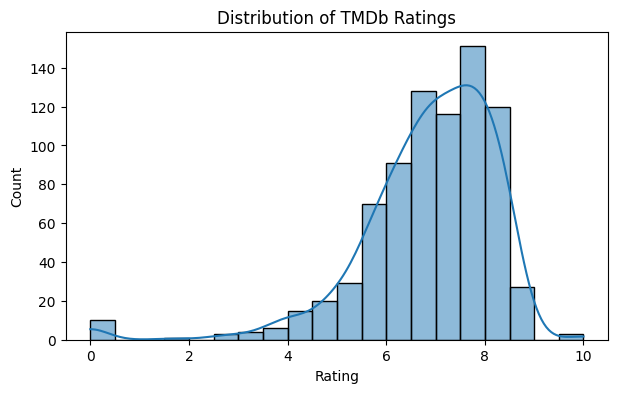

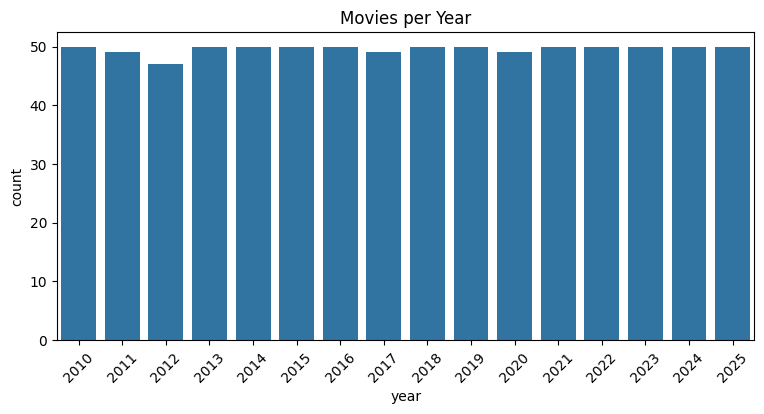

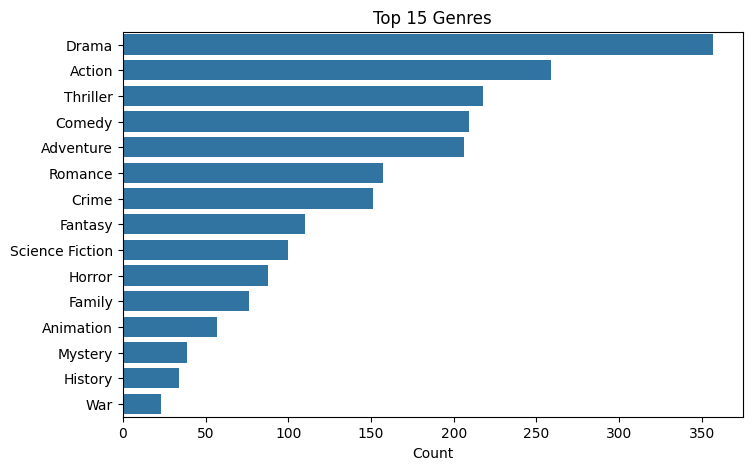

In [7]:
# === Cell 2: Quick EDA ===

# Convert columns
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["tmdb_rating"] = pd.to_numeric(df["tmdb_rating"], errors="coerce")

print("\n--- Summary Statistics ---")
print(df.describe(include="all"))

# Rating distribution
plt.figure(figsize=(7,4))
sns.histplot(df["tmdb_rating"].dropna(), bins=20, kde=True)
plt.title("Distribution of TMDb Ratings")
plt.xlabel("Rating")
plt.show()

# Movies per year
plt.figure(figsize=(9,4))
sns.countplot(x="year", data=df, order=sorted(df["year"].unique()))
plt.title("Movies per Year")
plt.xticks(rotation=45)
plt.show()

# Top genres frequency (split multiple genres)
from collections import Counter
genre_list = [g for sub in df["genres"].dropna().str.split("|") for g in sub]
top_genres = Counter(genre_list).most_common(15)
plt.figure(figsize=(8,5))
sns.barplot(x=[x[1] for x in top_genres], y=[x[0] for x in top_genres])
plt.title("Top 15 Genres")
plt.xlabel("Count")
plt.show()


In [8]:
# === Cell 2.5: Remove Duplicates ===

# Normalize title strings (trim spaces and lowercase for accurate matching)
df["title"] = df["title"].astype(str).str.strip()

# Drop exact duplicate rows first
before = len(df)
df.drop_duplicates(inplace=True)

# Drop duplicates by movie title (keeping the highest rated version)
df = df.sort_values(by="tmdb_rating", ascending=False)
df = df.drop_duplicates(subset=["title"], keep="first")

after = len(df)
print(f"✅ Removed {before - after} duplicate entries based on title or identical rows.")
print("Remaining unique movies:", after)


✅ Removed 276 duplicate entries based on title or identical rows.
Remaining unique movies: 518


✅ Added 18 new engineered features!


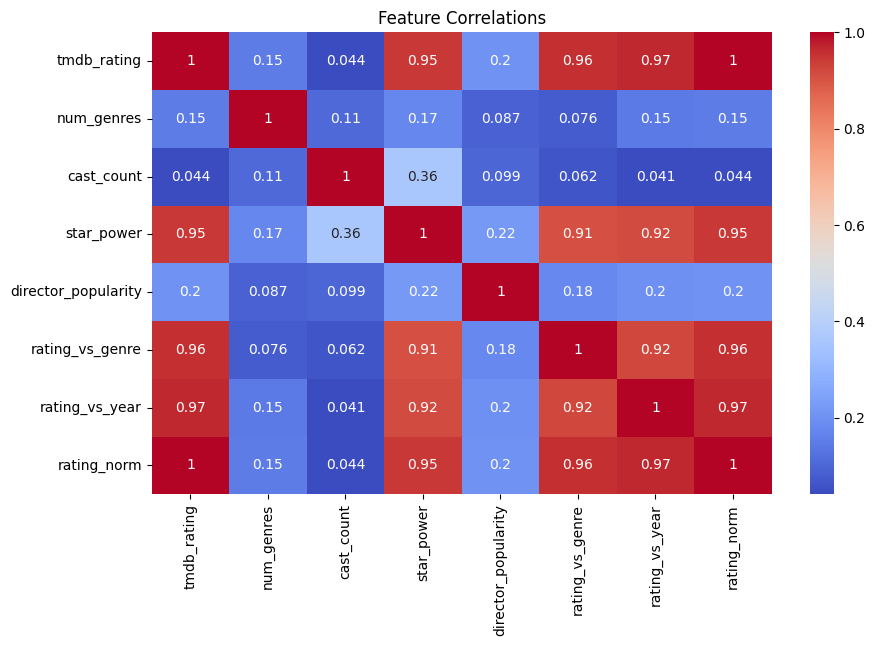

✅ Movies.db updated successfully with enhanced features.
Total rows saved: 518


In [9]:
# === Cell 3: Enhanced Feature Engineering + SQLite Export ===

import re
from collections import Counter

# 1️⃣ Temporal & structural features
df["decade"] = (df["year"] // 10 * 10).astype("Int64").astype(str) + "s"
df["num_genres"] = df["genres"].apply(lambda x: len(str(x).split("|")) if pd.notna(x) else 0)
df["main_genre"] = df["genres"].apply(lambda x: str(x).split("|")[0] if pd.notna(x) else None)
df["is_high_rated"] = (df["tmdb_rating"] >= 7).astype(int)
df["has_director"] = df["director"].notna().astype(int)
df["cast_count"] = df["cast_top5"].apply(lambda x: len(str(x).split("|")) if pd.notna(x) else 0)
df["region"] = df["language"].map({"hi": "Bollywood", "en": "Hollywood"}).fillna("Other")

# 2️⃣ Popularity & crew features
# Approximate "star power" = number of cast members listed × rating
df["star_power"] = df["cast_count"] * df["tmdb_rating"]

# Director popularity — frequency of director appearances
director_counts = df["director"].value_counts().to_dict()
df["director_popularity"] = df["director"].map(director_counts).fillna(0)

# 3️⃣ Genre-level aggregations
# Average rating by main genre (useful for normalization)
genre_avg = df.groupby("main_genre")["tmdb_rating"].mean().to_dict()
df["genre_avg_rating"] = df["main_genre"].map(genre_avg)

# Difference from genre average → "relative success"
df["rating_vs_genre"] = df["tmdb_rating"] - df["genre_avg_rating"]

# 4️⃣ Yearly trends
year_avg = df.groupby("year")["tmdb_rating"].mean().to_dict()
df["rating_vs_year"] = df["tmdb_rating"] - df["year"].map(year_avg)

# 5️⃣ Language-based categorization
df["is_english"] = (df["language"] == "en").astype(int)
df["is_hindi"] = (df["language"] == "hi").astype(int)
df["is_other_lang"] = (~df["language"].isin(["en", "hi"])).astype(int)

# 6️⃣ Title-based features
df["title_length"] = df["title"].apply(lambda x: len(str(x)))
df["has_number_in_title"] = df["title"].apply(lambda x: 1 if re.search(r"\d", str(x)) else 0)
df["has_colon"] = df["title"].apply(lambda x: 1 if ":" in str(x) else 0)
df["word_count_title"] = df["title"].apply(lambda x: len(str(x).split()))

# 7️⃣ Encoding the presence of known hit genres
hit_genres = ["Action", "Drama", "Comedy", "Romance", "Thriller"]
for g in hit_genres:
    df[f"has_{g.lower()}"] = df["genres"].apply(lambda x: 1 if pd.notna(x) and g in x else 0)

# 8️⃣ Normalized ratings for modeling (0–1 scale)
df["rating_norm"] = (df["tmdb_rating"] - df["tmdb_rating"].min()) / (df["tmdb_rating"].max() - df["tmdb_rating"].min())

# 🔍 Summary of added features
added_features = [
    "star_power", "director_popularity", "genre_avg_rating", "rating_vs_genre", "rating_vs_year",
    "is_english", "is_hindi", "is_other_lang", "title_length", "has_number_in_title", "has_colon",
    "word_count_title", "has_action", "has_drama", "has_comedy", "has_romance", "has_thriller", "rating_norm"
]
print(f"✅ Added {len(added_features)} new engineered features!")

# 📈 Quick correlation matrix for numeric features
numeric_cols = ["tmdb_rating", "num_genres", "cast_count", "star_power", "director_popularity", "rating_vs_genre", "rating_vs_year", "rating_norm"]
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

# 💾 Save to SQLite
conn = sqlite3.connect("Movies.db")
df.to_sql("movies", conn, if_exists="replace", index=False)
conn.commit()
conn.close()

print("✅ Movies.db updated successfully with enhanced features.")
print("Total rows saved:", len(df))
